# CNN LSTM Forescating model

Based on:
* [Time Series Forecasting on Stock Prices](https://www.youtube.com/watch?v=j05UUs99eNQ) from [Coding Tech](https://www.youtube.com/channel/UCtxCXg-UvSnTKPOzLH4wJaQ)
* https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

**Disclaimer:** _Investing in the stock market involves risk and can lead to monetary loss. This material is purely for educational purposes and should not be taken as professional investment advice. Invest at your own discretion._

Import the libraries

In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, TimeDistributed, Conv1D, MaxPooling1D

import matplotlib.pyplot as plt

Split an univariate sequence into samples

In [2]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # Find the end of the pattern
        end_ix = i + n_steps
        # Check if we are bound by sequence
        if end_ix > len(sequence) - 1:
            break
        # Gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

Load the data

In [3]:
df = pd.read_csv("SP500.csv")

Show the data

In [4]:
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2000-05-19,96.106028,96.106028,94.484962,94.779701,775500,0.0,0
1,2000-05-22,94.716551,94.716551,92.169162,94.190231,1850600,0.0,0
2,2000-05-23,94.463952,94.463952,92.758675,92.758675,373900,0.0,0
3,2000-05-24,92.800753,94.358660,92.063905,94.148132,400300,0.0,0
4,2000-05-25,94.337613,94.948145,92.884970,93.284973,69600,0.0,0
...,...,...,...,...,...,...,...,...
5359,2021-09-08,452.899994,453.679993,450.869995,453.000000,4076800,0.0,0
5360,2021-09-09,452.690002,454.579987,450.730011,450.980011,3851600,0.0,0
5361,2021-09-10,453.059998,453.510010,447.299988,447.540009,3023500,0.0,0
5362,2021-09-13,450.679993,450.929993,446.089996,448.579987,3007400,0.0,0


Add indices for every day in the period

In [5]:
start_date = df.Date.min()
end_date = df.Date.max()

In [6]:
df_date = pd.date_range(start=start_date, end=end_date).to_frame(name="Date")
df_date.reset_index(drop=True, inplace=True) 

In [7]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.merge(df_date, how='right')

Interpolate missing values

In [8]:
df = df.interpolate(method='linear', limit_direction='both')
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2000-05-19,96.106028,96.106028,94.484962,94.779701,7.755000e+05,0.0,0.0
1,2000-05-20,95.642869,95.642869,93.713029,94.583211,1.133867e+06,0.0,0.0
2,2000-05-21,95.179710,95.179710,92.941096,94.386721,1.492233e+06,0.0,0.0
3,2000-05-22,94.716551,94.716551,92.169162,94.190231,1.850600e+06,0.0,0.0
4,2000-05-23,94.463952,94.463952,92.758675,92.758675,3.739000e+05,0.0,0.0
...,...,...,...,...,...,...,...,...
7784,2021-09-10,453.059998,453.510010,447.299988,447.540009,3.023500e+06,0.0,0.0
7785,2021-09-11,452.266663,452.650004,446.896657,447.886668,3.018133e+06,0.0,0.0
7786,2021-09-12,451.473328,451.789998,446.493327,448.233327,3.012767e+06,0.0,0.0
7787,2021-09-13,450.679993,450.929993,446.089996,448.579987,3.007400e+06,0.0,0.0


Define input sequence

In [9]:
raw_seq = np.array(df.Close)

Choose a number of time steps

In [10]:
n_total_steps = 32
n_features = 1

In [11]:
n_steps = 8
n_seq = n_total_steps // n_steps

Split into samples

In [12]:
X, y = split_sequence(raw_seq[:-n_total_steps*n_seq], n_total_steps)

Reshape from [samples, timesteps] into [samples, timesteps, rows, columns, features]

In [13]:
X = X.reshape((X.shape[0], n_seq, n_steps, n_features))

Set test data

In [14]:
X_test, y_test = split_sequence(raw_seq[-n_total_steps*n_seq:], n_total_steps) 
X_test = X_test.reshape((X_test.shape[0], n_seq, n_steps, n_features))

Define model

In [15]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))

In [16]:
model.compile(optimizer='adam', loss='mse')

Fit model

In [17]:
model.fit(X, y, epochs=200)

Epoch 1/200
239/239 [==============================] - 1s 2ms/step - loss: 471.7784
Epoch 2/200
239/239 [==============================] - 1s 2ms/step - loss: 26.5370
Epoch 3/200
239/239 [==============================] - 1s 2ms/step - loss: 30.2024
Epoch 4/200
239/239 [==============================] - 1s 2ms/step - loss: 27.1227
Epoch 5/200
239/239 [==============================] - 1s 2ms/step - loss: 26.6632
Epoch 6/200
239/239 [==============================] - 1s 2ms/step - loss: 25.3073
Epoch 7/200
239/239 [==============================] - 1s 2ms/step - loss: 24.9745
Epoch 8/200
239/239 [==============================] - 1s 2ms/step - loss: 21.6552
Epoch 9/200
239/239 [==============================] - 1s 2ms/step - loss: 24.0939
Epoch 10/200
239/239 [==============================] - 1s 2ms/step - loss: 20.5471
Epoch 11/200
239/239 [==============================] - 1s 2ms/step - loss: 18.2437
Epoch 12/200
239/239 [==============================] - 1s 2ms/step - loss: 17.4275


239/239 [==============================] - 1s 5ms/step - loss: 3.7568
Epoch 197/200
239/239 [==============================] - 1s 4ms/step - loss: 3.8970
Epoch 198/200
239/239 [==============================] - 1s 5ms/step - loss: 3.6119
Epoch 199/200
239/239 [==============================] - 1s 4ms/step - loss: 3.4814
Epoch 200/200
239/239 [==============================] - 1s 5ms/step - loss: 3.6655


Demonstrate prediction

In [18]:
yhat = model.predict(X)

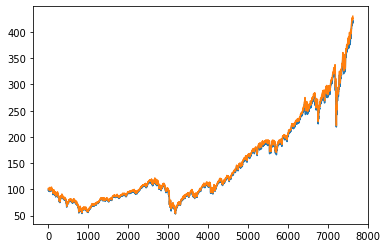

In [19]:
plt.plot(y)
plt.plot(yhat)
plt.show()

Demonstrate prediction

In [20]:
yhat = model.predict(X_test)

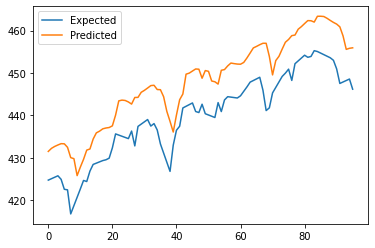

In [21]:
plt.plot(y_test, label="Expected")
plt.plot(yhat, label="Predicted")
plt.legend()
plt.show()

In [22]:
print(f"Predicted: {yhat[0][0]:.2f}  Expected: {y_test[0]:.2f}")

Predicted: 431.51  Expected: 424.74


**THIS IS NOT AN INVESTMENT ADVICE!**